### BiLSTM

In [1]:
# 종속변수

# 1) 향후 10분 후 종가 기준 리턴: returns
# 2) bid price 및 ask price 기준 10분 동안 실질적 리턴: returns_next10m
# 3) 10분 동안 realized volatility: realized_vol_next10m


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

### 1. Initialization

In [3]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# 최적화
import optuna

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns


'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데,
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''
torch.manual_seed(0)

# 맥북 용
# GPU 사용 가능 환경인지 확인 -> mac의 경우 GPU가 아는 MPS를 사용
print(f"mps 사용 가능 여부: {torch.backends.mps.is_available()}")
print(f"mps 지원 환경 여부: {torch.backends.mps.is_built()}")
device = torch.device("mps")

# 윈도우 용(Colab)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')

# 파라미터 초기화
# seq_length = 7 # 시퀀스 데이터 길이
# data_dim = 6 # Feature 개수
# hidden_dim = 10 # 은닉층 차원
# output_dim = 1 # 출력 차원
# learning_rate = 0.01 # 학습률
# epochs = 500 # 에폭, 학습 횟수
# batch_size = 100 # 배치 사이즈


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps 사용 가능 여부: True
mps 지원 환경 여부: True
mps is available


### 2. Data Preprocessing

In [4]:
# 학습용 데이터 셋 생성 함수
# Sequence data를 만들어서 numpy array로 반환
def build_dataset(data, seq_len):
    dataX = []
    dataY = []
    for i in range(len(data)-seq_len):
        x = data[i:i+seq_len, :]
        y = data[i+seq_len, [-1]]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_9.csv')
df = df.iloc[:1000]
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
print("before: ", df.shape)

# 무한대에 해당하는 값 제거
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Data Preprocessing
# 필요한 Feature만 추출한 데이터
target_var = df[['returns', 'returns_next10m', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'realized_vol_next10m'], inplace=True) # 독립변수
print("after: ", df.shape)
print(df.head())

# 독립변수 카테고리화
target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1

# 독립변수 중 사용할 변수만 가져오기(+정규화)
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id'])) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m'].values # 종속변수

# 성능을 기록할 데이터프레임
#result_df = pd.DataFrame()

before:  (1000, 84)
after:  (984, 81)
          window_start           window_end  num_rows  lowest_return  \
0  2022-12-16 21:05:30  2022-12-16 21:06:00        14       0.000000   
1  2022-12-16 21:06:00  2022-12-16 21:06:30        10       0.000000   
2  2022-12-16 21:06:30  2022-12-16 21:07:00        24      -0.000576   
3  2022-12-16 21:07:00  2022-12-16 21:07:30        22      -0.000044   
4  2022-12-16 21:07:30  2022-12-16 21:08:00        24      -0.000443   

   highest_return  high_low_gap  trade_vol  volume_power  beginning_price  \
0        0.000089      0.000089   1.468656      0.747351       22568000.0   
1        0.000089      0.000089   0.567585      0.027857       22568000.0   
2        0.000044      0.000620   1.677093      0.146635       22570000.0   
3        0.000443      0.000488   2.439677      0.751995       22557000.0   
4        0.000000      0.000443   2.345821     -0.915608       22565000.0   

   ending_price  ...  ob_end_bp_14  ob_end_bs_14 ob_end_bias_0  ob

/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_81987/3477799353.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1


In [3]:
# tmp_data = pd.concat([df, target_var['returns_next10m']], axis=1)
# tmp_data.to_csv('tmp_bitcoin_data.csv', index=False)

In [5]:
# 시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
        y_seq.append(y[i+sequence_length])

    # view를 사용하여 2차원으로 바꿈(MSE Loss가 기본적으로 2차원 타깃 데이터를 받음)
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

split = int(len(df)*0.7) # 70%를 학습 데이터로
sequence_length = 8 # 30s * 5 = 2m 30s를 시퀀스 길이로
x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())


torch.Size([688, 8, 77]) torch.Size([688, 1])
torch.Size([288, 8, 77]) torch.Size([288, 1])


/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_81987/1122436012.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [6]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)

In [15]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
        super(BiLSTM, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.sequence_length = sequence_length
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # 양방향 LSTM의 출력 크기는 hidden_size * 2입니다.
        self.fc = nn.Linear(hidden_size * 2, 1)  # 출력 크기를 1로 설정하여 수정

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device) # 양방향을 고려해야 하므로 * 2
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(self.device) # 양방향을 고려해야 하므로 * 2
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]  # 마지막 시퀀스의 출력만 사용
        out = self.fc(out)
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 적용
        return out


In [16]:
# 하이퍼 파라미터 정의
input_size = x_seq.size(2) # feature 개수
num_layers = 2 # 은닉층의 개수
hidden_size = 10 # 은닉 상태를 저장하는 벡터의 크기

In [17]:
# 모델 불러오기
model = BiLSTM(input_size=input_size,
             hidden_size=hidden_size,
             sequence_length=sequence_length,
             num_layers=num_layers,
             device=device).to(device)

In [18]:
# 손실 함수 및 최적화 방법 정의
criterion = nn.BCELoss()  # 손실 함수를 BCELoss로 변경
num_epochs = 20
optimizer = optim.Adam(model.parameters(), lr=1e-3) # 0.001


In [19]:
%%time
# 모델 학습하기
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
    running_loss = 0.0

    for data in train_loader:

        seq, target = data # 배치 데이터
        out = model(seq) # 출력값 산출
        loss = criterion(out, target) # 손실함수 계산

        optimizer.zero_grad()
        loss.backward()
        optimizer.step() # 최적화
        running_loss += loss.item()

    loss_graph.append(running_loss/n)
    if epoch % 100 == 0:
        print('[epoch: %d] loss: %.4f' %(epoch, running_loss/n))

[epoch: 0] loss: 0.7114
CPU times: user 2 s, sys: 172 ms, total: 2.17 s
Wall time: 3.81 s


In [20]:
# Optuna를 사용한 하이퍼파라미터 튜닝을 위한 objective 함수 수정
def objective(trial):
    # 하이퍼파라미터 탐색 공간 정의
    sequence_length = trial.suggest_int('sequence_length', 5, 20)
    input_size = x_seq.size()[2]
    hidden_size = trial.suggest_int('hidden_size', 5, 100)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    output_size = 1  # 출력 크기는 1
    num_epochs = trial.suggest_int('num_epochs', 100, 1000)
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)

    # Early stopping을 위한 변수 초기화
    patience = 5
    early_stopping_counter = 0
    best_loss = float('inf')

    # 모델 훈련 및 손실 계산
    model.train()
    for epoch in range(num_epochs):
        # Early stopping 체크
        if early_stopping_counter >= patience:
            break

        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # 평균 손실 계산
        epoch_loss /= len(train_loader)

        # Early stopping 체크
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
    
    # 여기서는 예시로 마지막 배치의 손실을 반환합니다. 실제로는 검증 데이터 세트에 대한 성능을 평가하여 반환해야 합니다.
    return best_loss

# Optuna 최적화 실행 부분은 동일
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # n_trials는 튜닝을 위한 시도 횟수

print('Best trial:', study.best_trial.params, '\n'
      "Best trial's values: ", study.best_trial.value)

[I 2024-02-20 15:04:15,306] A new study created in memory with name: no-name-8bc682b6-6218-4654-9639-b2997eac6ba5
/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_81987/270420347.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
[I 2024-02-20 15:04:20,362] Trial 0 finished with value: 0.488971209526062 and parameters: {'sequence_length': 20, 'hidden_size': 28, 'num_layers': 4, 'num_epochs': 556, 'lr': 0.00042787212994326187}. Best is trial 0 with value: 0.488971209526062.
[I 2024-02-20 15:04:21,713] Trial 1 finished with value: 0.4706181526184082 and parameters: {'sequence_length': 6, 'hidden_size': 76, 'num_layers': 3, 'num_epochs': 251, 'lr': 0.0003067143971728489}. Best is trial 1 with value: 0.4706181526184082.
[I 2024-02-20 15:04:24,008] Trial 2 finished with val

Best trial: {'sequence_length': 7, 'hidden_size': 60, 'num_layers': 3, 'num_epochs': 300, 'lr': 0.0033241721449366003} 
Best trial's values:  0.29526637494564056


0(negative) target ratio: 0.1640625
1(positive) target ratio: 0.8359375
-----------------------------------
Accuracy: 0.8359375
Precision: 0.8359375
Recall: 1.0
F1 Score: 0.9106382978723404
-----------------------------------


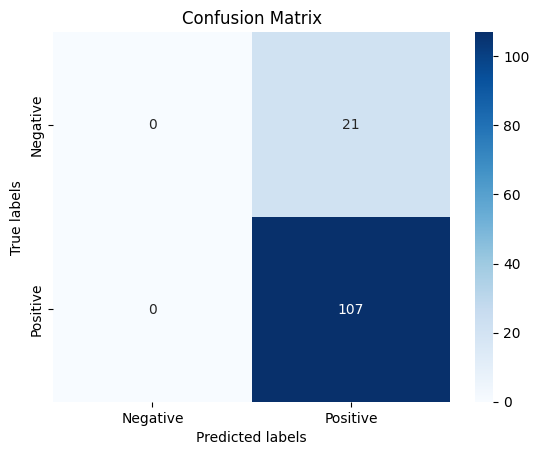

In [22]:
# 분류 성능 확인
# out = model(x)
predictions = torch.round(out).detach().cpu().numpy()  # 확률을 반올림하여 예측값 계산, CPU로 이동
target_np = target.detach().cpu().numpy()  # 실제 레이블을 numpy 배열로 변환, CPU로 이동

# Data imbalance check
print(f"0(negative) target ratio: {np.sum(target_np == 0) / len(target_np)}")
print(f"1(positive) target ratio: {np.sum(target_np == 1) / len(target_np)}")
print('-----------------------------------')

# metrics
accuracy = accuracy_score(target_np, predictions) # 정확도 계산
precision = precision_score(target_np, predictions) # 정밀도 계산
recall = recall_score(target_np, predictions) # 재현율 계산
f1 = f1_score(target_np, predictions) # F1 스코어 계산

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print('-----------------------------------')

# confusion matrix
cm = confusion_matrix(target_np, predictions) # 혼동 행렬 계산
fig, ax = plt.subplots() # 혼동 행렬 시각화
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)  # 혼동 행렬을 히트맵으로 표시
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()

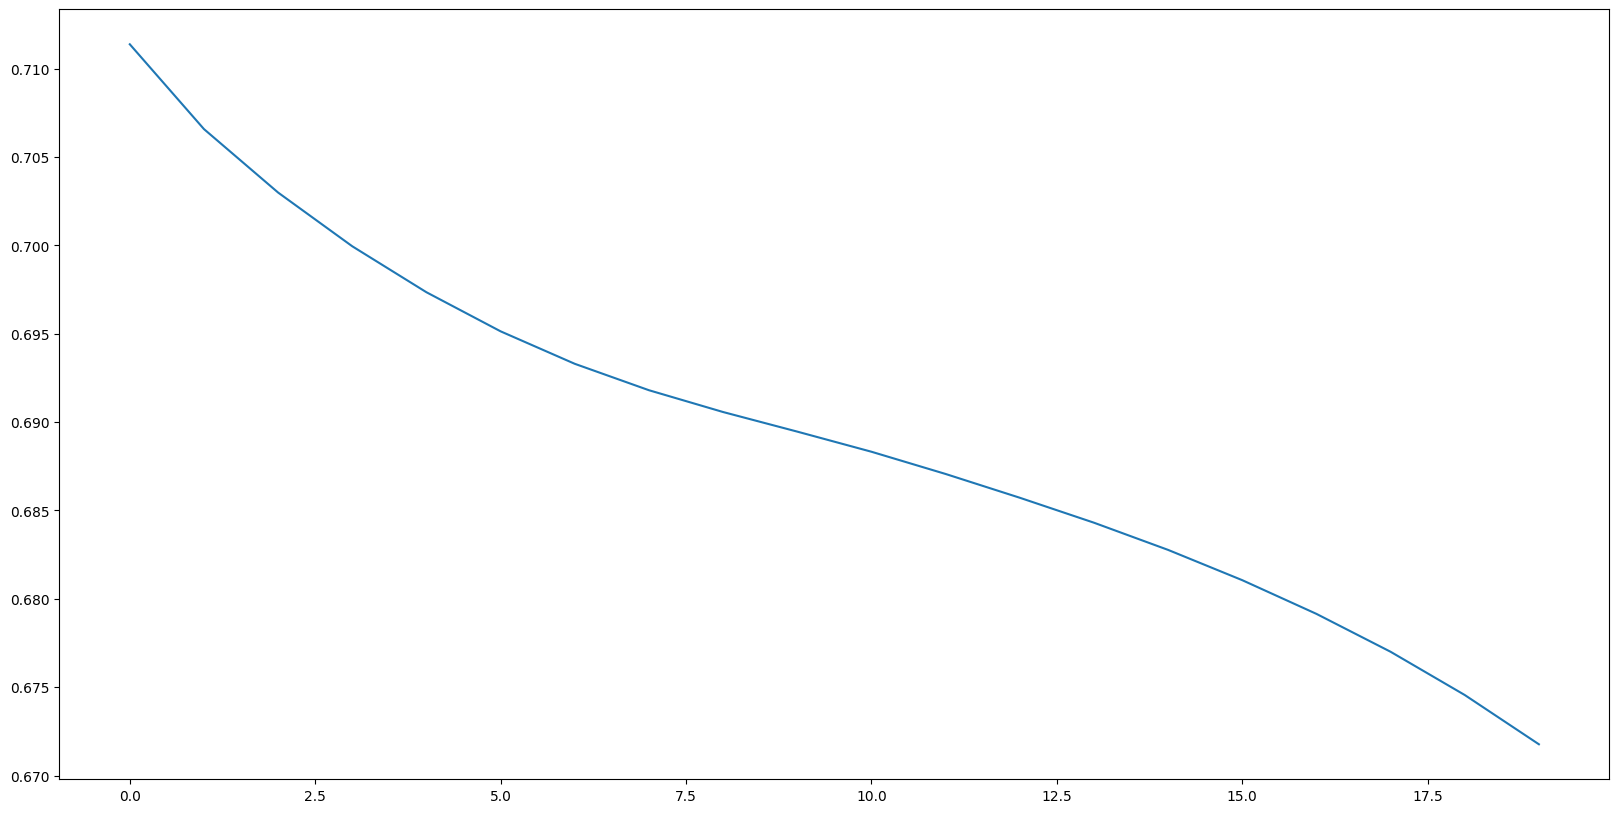

In [23]:
# 학습 손실 함수값 그리기
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

Epoch [10/300], Loss: 0.4531
Epoch [20/300], Loss: 0.3729
Epoch [30/300], Loss: 0.3314
Epoch [40/300], Loss: 0.3189
Epoch [50/300], Loss: 0.3149
Epoch [60/300], Loss: 0.3136
Epoch [70/300], Loss: 0.3238
Epoch [80/300], Loss: 0.3148
Epoch [90/300], Loss: 0.1859
Epoch [100/300], Loss: 0.1539
Epoch [110/300], Loss: 0.2437
Epoch [120/300], Loss: 0.0928
Epoch [130/300], Loss: 0.0769
Epoch [140/300], Loss: 0.0469
Epoch [150/300], Loss: 0.2224
Epoch [160/300], Loss: 0.0433
Epoch [170/300], Loss: 0.0813
Epoch [180/300], Loss: 0.1462
Epoch [190/300], Loss: 0.0573
Epoch [200/300], Loss: 0.0270
Epoch [210/300], Loss: 0.2768
Epoch [220/300], Loss: 0.1013
Epoch [230/300], Loss: 0.0333
Epoch [240/300], Loss: 0.0286
Epoch [250/300], Loss: 0.1507
Epoch [260/300], Loss: 0.3187
Epoch [270/300], Loss: 0.1053
Epoch [280/300], Loss: 0.0579
Epoch [290/300], Loss: 0.0344
Epoch [300/300], Loss: 0.0279
Accuracy: 0.6528
Precision: 0.5193
Recall: 0.8785
F1 Score: 0.6528


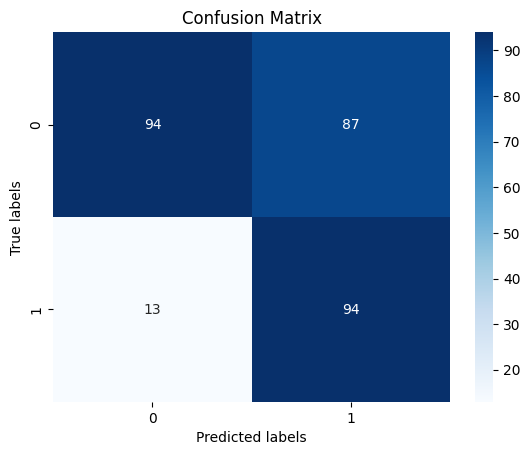

In [29]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 최적 하이퍼파라미터 사용하여 모델 초기화
best_trial = study.best_trial
model = BiLSTM(
    input_size=x_train_seq.size(2),
    hidden_size=best_trial.params['hidden_size'],
    sequence_length=8,
    num_layers=best_trial.params['num_layers'],
    device=device).to(device)

# 모델 훈련을 위한 설정
optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['lr'])  # 최적화 알고리즘 설정
criterion = nn.BCELoss()  # 손실 함수 설정 (이진 분류를 가정)

# 훈련 과정 설정
num_epochs = best_trial.params['num_epochs']  # 에폭 수

# 훈련 시작
model.train()  # 모델을 훈련 모드로 설정
for epoch in range(num_epochs):
    for x_batch, labels in train_loader:
        x_batch, labels = x_batch.to(device), labels.to(device)
        
        # 순전파: 모델에 데이터를 입력하여 예측값을 계산
        outputs = model(x_batch)
        
        # 손실 계산
        loss = criterion(outputs, labels)
        
        # 역전파: 손실에 대한 모델의 매개변수들의 미분값을 계산
        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파 실행
        
        # 매개변수 업데이트
        optimizer.step()
    
    # 에폭마다 진행 상황 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.round(outputs).cpu().numpy()  # 이진 분류를 가정
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()